In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importando bibliotecas

In [2]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [4]:
path2data = '' # Coloque aqui o diretório onde encontra-se o csv com os dados. 

# Objetivo 

A partir de uma série temporal multivariável real, determine as matrizes de um modelo gaussiano linear em espaço de estados que melhor represente utilizando algum algoritmo de realização de séries temporais variantes ou invariantes no tempo. A partir do modelo em espaço de estado faça a estimação dos estados e das saídas no conjunto completo dos dados e compare as saídas estimadas com as reais. Use a inicialização exata.

# Funções auxiliares

In [5]:
# Source: http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [121]:
def is_invertible(a):
    return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]

Aqui foi implementado e testado a iniciaização exata baseado no conteúdo dado em sala de aula e na [solução](https://github.com/ChadFulton/tsa-notebooks/blob/master/code_state_space.ipynb) proposta por Chad Fulton.

Para a previsão da série temporal multivariável escolhida nesta prova, não foi possível utilizar desta implementação devido a problemas de arrendondamento e matrizes próximas a singularidade. Dado também minha pouca disponibilidade de tempo, não foi possível implementar a versão de Raiz Quadrada do filtro de Kalman o qual lida com este tipo de problema. De qualquer maneira coloco o código a disposição para futuras melhorias. 

In [7]:
def kalman_filter(y, Z, H, T,a_0,P_0,exact,a,A,R_0,Q_0):
    # Dimensions
    k_endog, nobs = y.shape
    k_states = T.shape[0]

    # Allocate memory for variables
    filtered_state = np.zeros((k_states, nobs))
    filtered_state_cov = np.zeros((k_states, k_states, nobs))
    predicted_state = np.zeros((k_states, nobs+1))
    predicted_state_cov = np.zeros((k_states, k_states, nobs+1))
    forecast = np.zeros((k_endog, nobs))
    forecast_error = np.zeros((k_endog, nobs))
    forecast_error_cov = np.zeros((k_endog, k_endog, nobs))
    loglikelihood = np.zeros((nobs+1,))

    
    d=0
    if exact :
        # P finito
        filtered_state_cov_fin = np.zeros((k_states, k_states, nobs))
        filtered_state_cov_fin[:,:,0] = np.dot(A,A.T)

        # P infinito
        filtered_state_cov_inf = np.zeros((k_states, k_states, nobs))
        filtered_state_cov_inf[:,:,0] = np.dot(np.dot(R_0,Q_0),R_0.T)

        # F infinito
        forecast_error_cov_inf = np.zeros((k_endog, k_endog, nobs))
        # F finito
        forecast_error_cov_fin = np.zeros((k_endog, k_endog, nobs))

        predicted_state[:, 0] = a

        #F infinito não singular
        if is_invertible(forecast_error_cov_inf[:,:,0]) and d<(nobs-1):
            while np.linalg.det(filtered_state_cov_inf[:,:,d]) != 0:
                # F infinito
                forecast_error_cov_inf[:,:,d] = np.dot(np.dot(Z,filtered_state_cov_inf[:,:,d]),
                                                       Z.T)
                # F finito
                forecast_error_cov_fin[:,:,d] = np.dot(np.dot(Z,filtered_state_cov_fin[:,:,d]),
                                                              Z.T) + H

                f_1 = np.linalg.inv(forecast_error_cov_inf[:,:,d])
                f_2 = - np.dot(np.dot(f_1,forecast_error_cov_fin[:,:,d]),f_1)

                M_inf = np.dot(filtered_state_cov_inf[:,:,d],Z.T)
                M_fin = np.dot(filtered_state_cov_fin[:,:,d],Z.T)

                # Ganho de Kalman
                k_0 = np.dot(np.dot(T,M_inf),f_1)
                k_1 = np.dot(np.dot(T,M_fin),f_1) + np.dot(np.dot(T,M_inf),f_2)

                # L
                l_0 = T - np.dot(k_0,Z)
                l_1 = - np.dot(k_1,Z) 

                # Forecast for time d
                forecast[:, d] = np.dot(Z, predicted_state[:, d])
                # Forecast error for time d
                forecast_error[:, d] = y[:, d] - forecast[:, d]




                # Predicted state for time t+1
                predicted_state[:, d+1] = np.dot(T, predicted_state[:, d]) + np.dot(k_0,forecast_error[:, d])

                # P finito
                filtered_state_cov_fin[:,:,d+1] = ( np.dot(np.dot(T,filtered_state_cov_inf[:,:,d]),l_1.T) +
                                                    np.dot(np.dot(T,filtered_state_cov_fin[:,:,d]),l_0.T) + 
                                                    np.dot(np.dot(R_0,Q_0),R_0.T) )
                # P infinito
                filtered_state_cov_inf[:,:,d+1] = np.dot(np.dot(T,filtered_state_cov_inf[:,:,d]),l_0.T)

                d+=1     

        else:


            while (filtered_state_cov_inf[:,:,d]> 1e-18).any() and d<(nobs-1):
                # F finito
                forecast_error_cov_fin[:,:,d] = np.dot(np.dot(Z,filtered_state_cov_fin[:,:,d]),
                                                       Z.T) + H                

                # M
                M_inf = np.dot(filtered_state_cov_inf[:,:,d],Z.T)
                M_fin = np.dot(filtered_state_cov_fin[:,:,d],Z.T)                


                tmp = np.linalg.inv(forecast_error_cov_fin[:,:,d])

                # Ganho de Kalman
                k_0 = np.dot(np.dot(T,M_inf),tmp)                
                # L
                l_0 = T - np.dot(k_0,Z)                

                # Forecast for time d
                forecast[:, d] = np.dot(Z, predicted_state[:, d])
                # Forecast error for time d
                forecast_error[:, d] = y[:, d] - forecast[:, d]

                # Predicted state for time t+1
                predicted_state[:, d+1] = np.dot(T, predicted_state[:, d]) + np.dot(k_0,forecast_error[:, d])                

                # P finito
                filtered_state_cov_fin[:,:,d+1] = ( np.dot(np.dot(T,filtered_state_cov_fin[:,:,d]),l_0.T) + 
                                                    np.dot(np.dot(R_0,Q_0),R_0.T) )
                # P infinito
                filtered_state_cov_inf[:,:,d+1] = np.dot(np.dot(T,filtered_state_cov_inf[:,:,d]),T.T)

                d+=1                         
    else:
        # Copy initial values to predicted

        predicted_state[:, 0] = a_0
        predicted_state_cov[:, :, 0] = P_0
        
        
    print(d)
    Q = Q_0.copy()
    
    # Kalman filter iterations
    for t in range(d,nobs):
        print(t)
        # Forecast for time t
        forecast[:, t] = np.dot(Z, predicted_state[:, t])

        # Forecast error for time t
        forecast_error[:, t] = y[:, t] - forecast[:, t]

        # Forecast error covariance matrix and inverse for time t
        tmp1 = np.dot(predicted_state_cov[:, :, t], Z.T)
        forecast_error_cov[:, :, t] = (
            np.dot(Z, tmp1) + H
        )
        forecast_error_cov_inv = np.linalg.inv(forecast_error_cov[:, :, t])
        determinant = np.linalg.det(forecast_error_cov[:, :, t])

        # Filtered state for time t
        tmp2 = np.dot(forecast_error_cov_inv, forecast_error[:,t])
        filtered_state[:, t] = (
            predicted_state[:, t] +
            np.dot(tmp1, tmp2)
        )

        # Filtered state covariance for time t
        tmp3 = np.dot(forecast_error_cov_inv, Z)
        filtered_state_cov[:, :, t] = (
            predicted_state_cov[:, :, t] -
            np.dot(
                np.dot(tmp1, tmp3),
                predicted_state_cov[:, :, t]
            )
        )

        # Loglikelihood
        loglikelihood[t] = -0.5 * (
            np.log((2*np.pi)**k_endog * determinant) +
            np.dot(forecast_error[:, t], tmp2)
        )

        # Predicted state for time t+1
        predicted_state[:, t+1] = np.dot(T, filtered_state[:, t])

        # Predicted state covariance matrix for time t+1
        tmp4 = np.dot(T, filtered_state_cov[:, :, t])
        predicted_state_cov[:, :, t+1] = np.dot(tmp4, T.T) + Q
        
        predicted_state_cov[:, :, t+1] = (
            predicted_state_cov[:, :, t+1] + predicted_state_cov[:, :, t+1].T
        ) / 2

    if exact: 
        res = {'filtered_state':filtered_state, 'filtered_state_cov':filtered_state_cov,'predicted_state':predicted_state,
               'predicted_state_cov':predicted_state_cov,'forecast':forecast,'forecast_error':forecast_error,
                'forecast_error_cov':forecast_error_cov, 'loglikelihood':loglikelihood}
    else: 
        res = {'filtered_state':filtered_state, 'filtered_state_cov':filtered_state_cov,'predicted_state':predicted_state,
               'predicted_state_cov':predicted_state_cov,'forecast':forecast,'forecast_error':forecast_error,
               'forecast_error_cov':forecast_error_cov, 'loglikelihood':loglikelihood,
                'filtered_state_cov_fin':filtered_state_cov_fin,'filtered_state_cov_inf':filtered_state_cov_inf}

    return res

# Descrição dos dados

O dataset contém 9358 amostras de respostas médias de um conjunto de 5 sensores químicos de óxido de metal em um dispositovo denominado por : *Air Quality Chemical Multisensor*. O dispositivo estava situadoem campo em uma regiões consideravelmente poluída, na alturada da estrada, dentro de uma cidade Italiana. OS dados foram extraídos no período de Março de 2004 a Fevereiro de 2005 (um ano) representando o maior conjunto de dados gratuitamente disponível de sensores de qualidade química de ar localizados em campo. O mesmo pode ser encontrado neste [link](https://archive.ics.uci.edu/ml/datasets.html).

Informação sobre as características dos dados:

- Date:	(DD/MM/YYYY) 
- Time:	(HH.MM.SS) 
- True hourly averaged concentration CO in mg/m^3 (reference analyzer) 
- PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)	
- True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) 
- True hourly averaged Benzene concentration in microg/m^3 (reference analyzer) 
- PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)	
- True hourly averaged NOx concentration in ppb (reference analyzer) 
- PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 
- True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)	
- PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)	
- PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) 
- Temperature in Â°C	
- Relative Humidity (%) 
- AH Absolute Humidity 



In [35]:
data = pd.read_csv(f'{path2data}AirQualityUCI.csv',sep=';')
data.drop(columns=['Time','Unnamed: 15','Unnamed: 16'],inplace=True)

Aqui foram removidos os valores nulos do dataset

In [36]:
data= data[~data['Date'].isnull()]
data.reset_index(inplace=True,drop=True)

In [37]:
data.head(2)

,Date,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"


Foi analisado a distribuição de cada série temporal:

In [38]:
data.describe()

,PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,1048.990061,-159.090093,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032
std,329.832710,139.789093,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,921.000000,-200.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000
50%,1053.000000,-200.000000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000
75%,1221.000000,-200.000000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000
max,2040.000000,1189.000000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000


# Análise Estatística das séries temporais

Foi escolhido a concetraçao de **Monóxido de Carbono CO** e **Óxido de tungstenio NOx**, para a realização e previsão de suas respectivas séries temporais.

In [39]:
data = data[['PT08.S1(CO)','PT08.S3(NOx)']]
data.columns= ['CO','NOx']
data.shape

(9357, 2)

In [40]:
data =  data[(data['NOx']!=-200)|(data['CO']!=-200)] # Dropando valores marcados como nulo == -200

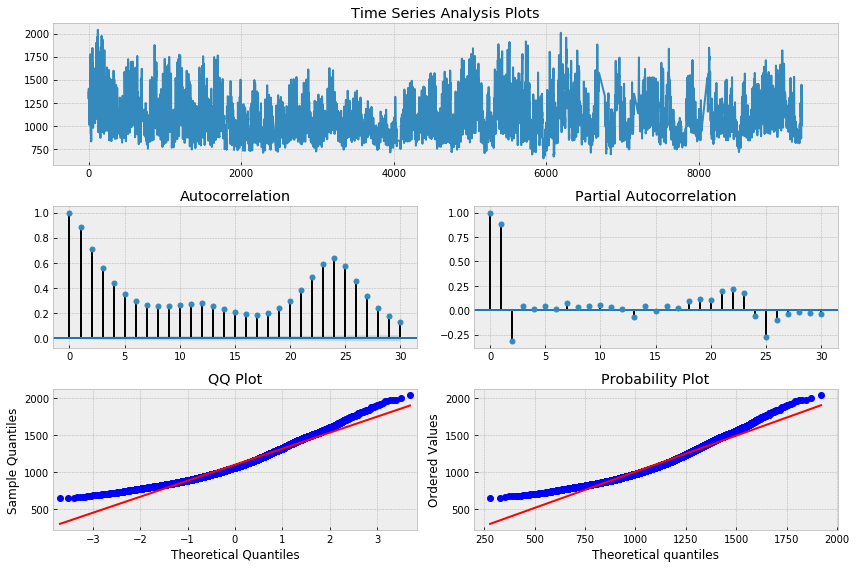

In [41]:
tsplot(data['CO'],30,(12,8)) 

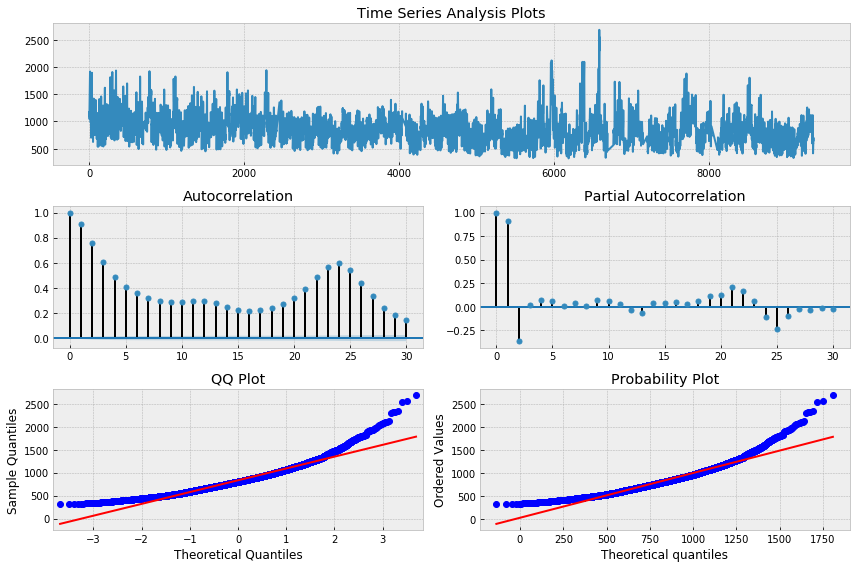

In [42]:
tsplot(data['NOx'],30,(12,8))

Após analisar as propriedades estastísticas de cada série, observou-se a necessidade de diferenciar ambas com o intuito de remover a componente de tendência, obtendo o seguinte resultado: 

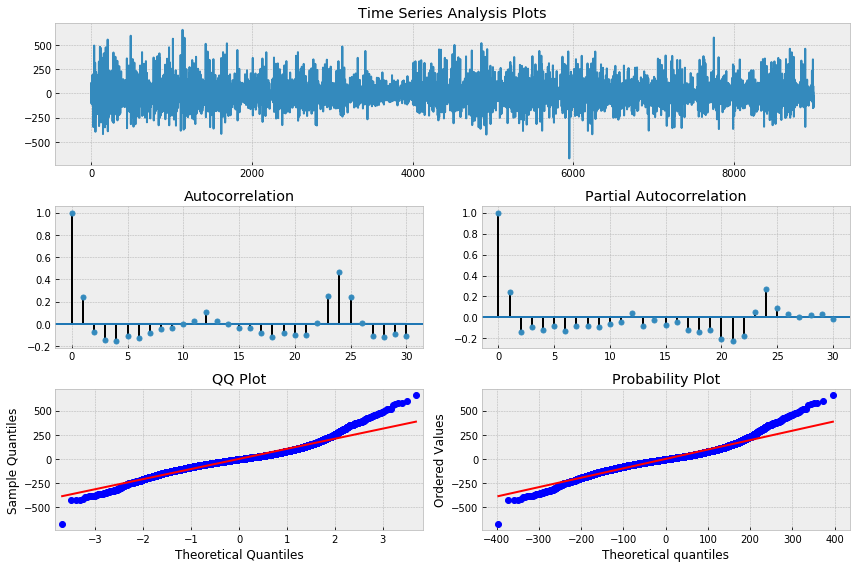

In [43]:
tsplot(np.diff(data['CO']),30,(12,8))

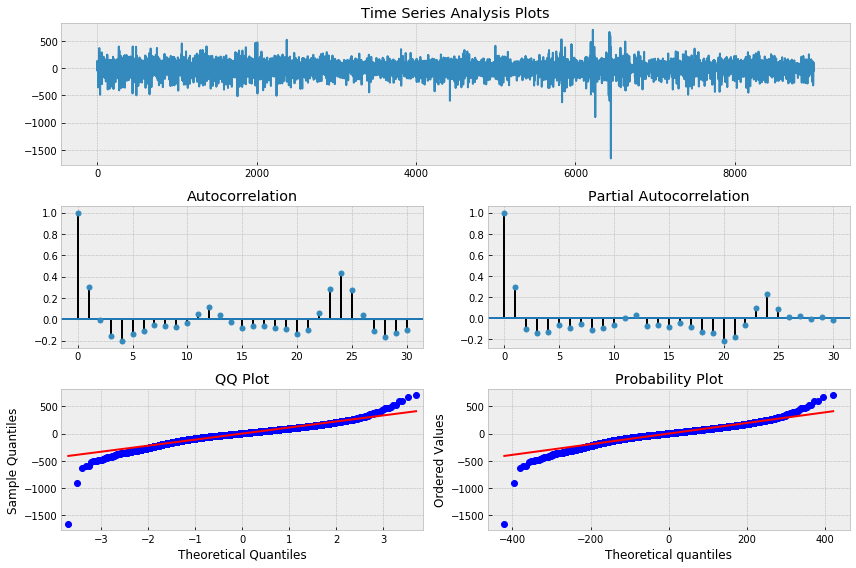

In [44]:
tsplot(np.diff(data['NOx']),30,(12,8))

Foi possível então obter uma representação estacionária de ambas as séries. 

In [45]:
data_stat = pd.DataFrame({'CO':np.diff(data['CO']),
                          'NOx':np.diff(data['NOx'])}) # Salvando as séries diferenciadas em um novo Dataframe

In [46]:
data_stat.shape

(8990, 2)

# Modelo proposto

Para modelar os padrões referentes as séries temporais escolhidas foi escolhido a princípio o modelo Vector Autoregressions:


$$
Y_t = A_1 Y_{t-1} + \ldots + A_p Y_{t-p}+ u_t + , \qquad u_t \sim N(0, \Sigma_u)
$$

onde $A$ é uma matrize de dimensão ($k\times k$) e $Y_t$ com dimensão $(n_{obs} \times k)$.

Para este caso temos $k = 2$ representando as duas séries temporais que deseja-se modelar: A concentração de monóxido de carbono CO e a concetração de óxido de tungstenio NOx, ambas com um número de observações $n_{obs} = 8990$

Aqui foi utilizado da biblioteca [StatsModels](http://www.statsmodels.org/stable/index.html), em particular do módulo para análise de séries temporais: `statsmodels.tsa`.

In [98]:
model = sm.tsa.VARMAX(data_stat,order=(25,0))

Foi escolhido o tipo de inicialização exata para as recursões do filtro de Kalman, onde o estado inicial é descrito da seguinte maneira. Média sendo: 
$$
\alpha_1 = a + A\delta +R_o\eta_o \ \mbox{;} \
$$

e variância : 
$$
P_t^{\dagger} =[\kappa P_{\infty} + P_{\ast}] \ \mbox{;} \
 L_t^{\dagger} =\begin{bmatrix}L_t^{0}&L_t^{1}\\
                          0&L_t^{0}\end{bmatrix}
$$

onde $P_{\infty}=AA^T \ \mbox{;} \ P_{\ast}=R_0Q_0R_0^T \ \mbox{;} \  L_t^{0} = T_t - K_t^{0}Z{t} \ \mbox{;} \  L_t^{1} = 0 $

No capítulo 5 no livro [2] é demonstrado que após $d$ iterações $P_{\infty}$ se torna uma matriz nula. Onde $d<n$ sendo $n$ o número de observações das séries temporais.  

Na biblioteca StatsModels esta e outras funcionalidads já estão implementadas e otimizadas tratando exceções como o caso de matrizes perto da singularidade. É possível verificar as funcionalidades do filtro Kalman na [documentação](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.kalman_filter.KalmanFilter.html) e na própria implementação no disponível no [GitHub](https://github.com/statsmodels/statsmodels/blob/master/statsmodels/tsa/kalmanf/kalmanfilter.py)

Para a ativação desta funcionalidade basta setar a flag `filter_exact_initial` com o valor `True`.

In [99]:
model.set_filter_method(filter_exact_initial=True)

Para a estimação dos parâmetros dos regressores da matriz $A$ foi utilizado da técnica de mínimos quadrados.[1]

$$ A = (X^{T}X)^{-1}X^{T}y$$

Onde A é a matriz dos regressores para cada série temporal, $X$ contendo os atrasos (p) e $y$ a saída observável. 

Para as variâncias e covariâncias presentes em $\Sigma_u$, foi utilizado de máximo verossimilhança, obtida diretamente das recursões do filtro de Kalman. Como apresentado a seguir : 

\begin{equation*}
\mathcal{L}(Y_n \ | \ \psi) = -0.5 (\log(2\pi)^{k_{endog} \ * \ |F_t|} + v_ta_{t \ | \ t})
\end{equation*} 

onde $k_{endog}$ : Número de exemplos da série $y_t$, $|F_t|$ determinante da matriz de covariância da inovação [2].



Na biblioteca StatsModels utilizando o objeto model é possível invocar o método `fit()` onde é aplicado a técnica de mínimos quadrados e é feito um processo de otimização buscando maximizar o valor da máximo verossimillhança das recursões do filtro de Kalman, utilizando o método Broyden-Fletcher-Goldfarb-Shanno (BFGS) selecionado pelo parâmetro `method = 'lbfgs'`. 

In [100]:
results = model.fit(method='lbfgs',maxiter=1000)

Aqui é válido ressaltar que o número de regressores escolhidos $(p=25)$, foi decidido baseado na análise visual dos gráficos de autocorrelação das séries onde mesmo após o processo de diferenciação é possível observar picos de correlação para os atrasos 1 e 25 em particular.  

Foram testados ambos os valores $p=1$ e $p=25$ comparando-se via métrica AIC/BIC e Máximo Verossilmilhança (*LogLikelihood*), como apresentado no resumo a seguir:

In [97]:
# Resultado para p = 1

print(results.summary())

                           Statespace Model Results                           
Dep. Variable:          ['CO', 'NOx']   No. Observations:                 8990
Model:                         VAR(1)   Log Likelihood             -104505.890
                          + intercept   AIC                         209029.781
Date:                Sat, 30 Jun 2018   BIC                         209093.716
Time:                        19:46:40   HQIC                        209051.537
Sample:                             0                                         
                               - 8990                                         
Covariance Type:                  opg                                         
Ljung-Box (Q):             2979.95, 961.60   Jarque-Bera (JB):   3639.70, 1610169.54
Prob(Q):                        0.00, 0.00   Prob(JB):                    0.00, 0.00
Heteroskedasticity (H):         0.72, 1.47   Skew:                       0.23, -2.20
Prob(H) (two-sided):            0.

In [101]:
# Resultado para p= 25 
# Obsva-se uma maior Maximo verosimilhança e um menor AIC/BIC
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:          ['CO', 'NOx']   No. Observations:                 8990
Model:                        VAR(25)   Log Likelihood             -102054.669
                          + intercept   AIC                         204319.338
Date:                Sat, 30 Jun 2018   BIC                         205065.244
Time:                        19:52:17   HQIC                        204573.165
Sample:                             0                                         
                               - 8990                                         
Covariance Type:                  opg                                         
Ljung-Box (Q):               118.60, 92.08   Jarque-Bera (JB):   2990.28, 1048020.92
Prob(Q):                        0.00, 0.00   Prob(JB):                    0.00, 0.00
Heteroskedasticity (H):         0.87, 1.60   Skew:                       0.34, -0.91
Prob(H) (two-sided):            0.

# Análise dos resíduos 

Nesta seção é conduzida uma análise dos resíduos após ter sido feita a estimação tanto dos regressores quanto das variâncias dos ruídos.

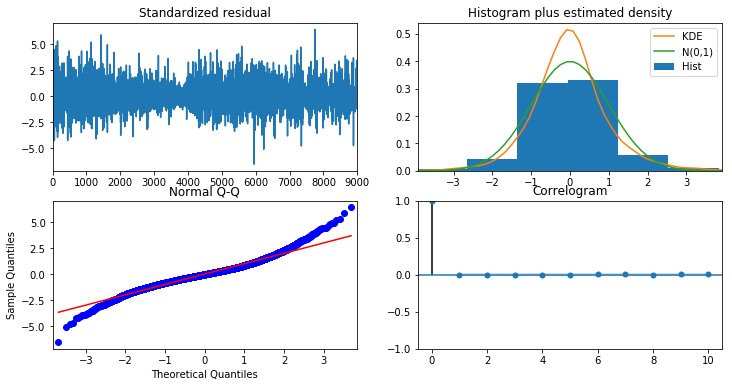

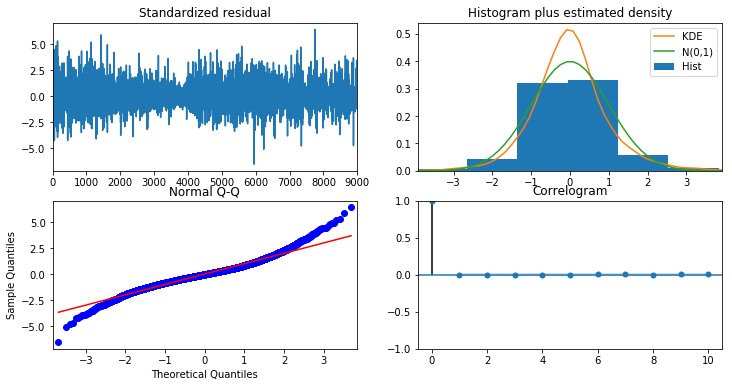

In [103]:
results.plot_diagnostics(figsize=(12,6))

Podemos obseervar que os ruídos são descorrelacionados temporalmente e se aproximam de uma distribuição gaussiana. O que é um excelente sinal. 

# Análise das covariâncias $V_t$  e $P_t$

Como esperado observamos que $V_t$ < $P_t$ indicando que o processo de refinamento dos estados foi bem sucedido.

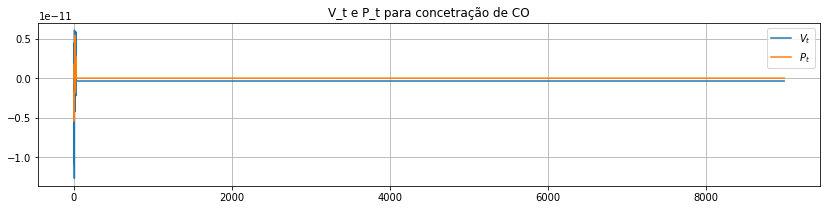

In [115]:
plt.figure(figsize=(14,3))
plt.plot(results.smoothed_state_cov[0, 0],label=r'$V_t$')
plt.plot(results.filtered_state_cov[0, 0],label=r'$P_t$')
plt.legend()
plt.title('V_t e P_t para concetração de CO')
plt.grid()
plt.show()

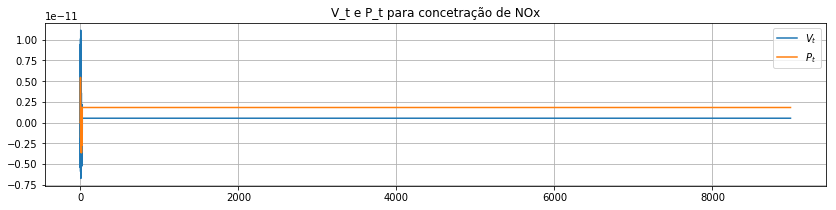

In [116]:
plt.figure(figsize=(14,3))
plt.plot(results.smoothed_state_cov[1, 0],label=r'$V_t$')
plt.plot(results.filtered_state_cov[1, 0],label=r'$P_t$')
plt.legend()
plt.title('V_t e P_t para concetração de NOx')
plt.grid()
plt.show()

# Comparando predições com a saída

Nesta seção é apresentada uma comparação entre os valores preditos e reais das séries analisadas

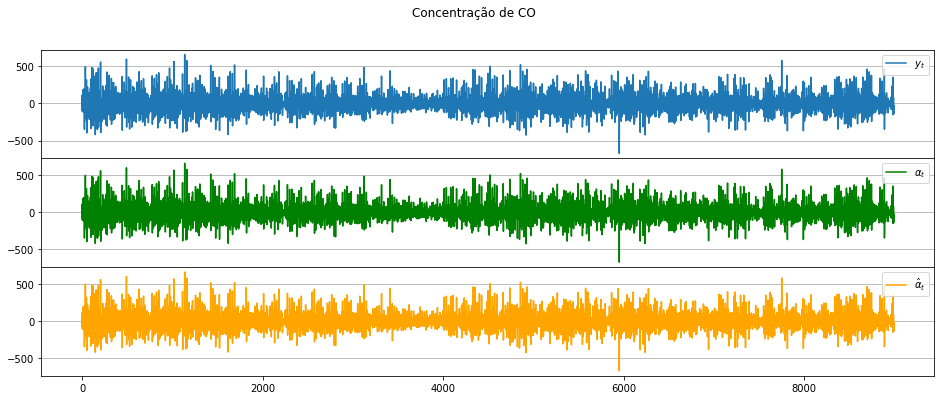

In [117]:
f, axarr = plt.subplots(3, sharex=True, sharey=True,figsize=(16,6))

f.suptitle('Concentração de CO')
axarr[0].plot(data_stat['CO'].values,label=r'$y_t$',)
axarr[1].plot(results.filtered_state[0],label=r'$\alpha_t$',c='g')
axarr[2].plot(results.smoothed_state[0],label=r'$\hat{\alpha}_t$',c='orange')
# Bring subplots close to each other.
f.subplots_adjust(hspace=0)
# Hide x labels and tick labels for all but bottom plot.
for ax in axarr:
    ax.yaxis.grid()
    ax.legend(loc='upper right', labelspacing=0.3);

In [118]:
from sklearn.metrics import mean_squared_error as mse


mse(data_stat['CO'].values,results.filtered_state[0]),mse(data_stat['CO'].values,results.smoothed_state[0])

(1.290606961165988e-28, 2.8289879139442492e-28)

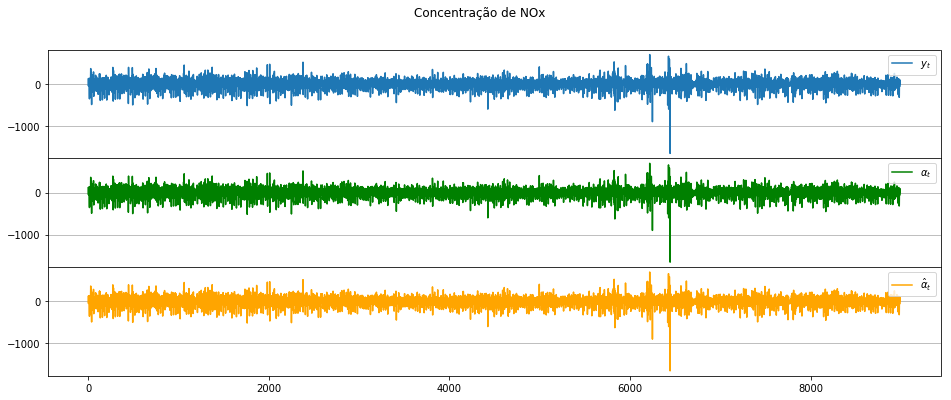

In [119]:
f, axarr = plt.subplots(3, sharex=True, sharey=True,figsize=(16,6))

f.suptitle('Concentração de NOx')
axarr[0].plot(data_stat['NOx'].values,label=r'$y_t$',)
axarr[1].plot(results.filtered_state[1],label=r'$\alpha_t$',c='g')
axarr[2].plot(results.smoothed_state[1],label=r'$\hat{\alpha}_t$',c='orange')
# Bring subplots close to each other.
f.subplots_adjust(hspace=0)
# Hide x labels and tick labels for all but bottom plot.
for ax in axarr:
    ax.yaxis.grid()
    ax.legend(loc='upper right', labelspacing=0.3);

In [120]:
from sklearn.metrics import mean_squared_error as mse


mse(data_stat['NOx'].values,results.filtered_state[1]),mse(data_stat['NOx'].values,results.smoothed_state[1])

(1.5626685718503406e-28, 2.934027192376291e-28)

# Conclusões

O célebre filtro de Kalman juntamente com a representação de modelos matemáticos na forma de espaço e estados é definitivamente uma ferramenta muito versátil e robusta que deve ser explorada para soluções que envolvem a realização e predição de séries temporais. 

A possibilidade da utilização de métodos de estimação de parâmetros como a Máximo Verossimilhança através das recursões do filtro de Kalman, abrangem consideravelmente as capacidades desta ferramenta para aplicações em cenários reais. Esta característica somada aos modelos clássicos estruturais e ou da família dos modelos auto-regressivos evitam ainda trabalhos mais profundos ligados a identifição de sistemas em caixa branca que nem sempre são factíveis. 

Para este exemplo em particular os resultados obtidos foram satisfatórios, demonstrando convergência dos estados e um baixo erro quadrado médio na predição da saída.


Após este intenso semestre de atividades é com grande prazer que olho para este singelo trabalho e consigo observar o progresso de meu entendimento quando comparado ao início deste turbulento período. Sabendo ainda que há uma extensa jornada a ser trilhada e que me encontro apenas no início da mesma, é gratificante poder comemorar tais pequenas vitórias. Gostaria de enfatizar o excelente trabalho e deixar os meus sinceros agradecimentos ao [Dr. Mateus Giesbrecht](http://lattes.cnpq.br/7480104217250652) que foi o grande facilitador e acelerador de tal aprendizado. 


Aqui deixo o registro do meu muito obrigado.

Euler Rodrigues de Sousa Faria

# Referências

[1]Chad, F (2017). Estimating time series models by state space methods in Python: Statsmodels.

[2]Durbin., J and Koopman, S.J. Time Series Analysis by State Space Methods.